# Local Volatility

We offer you the following practical task on the local volatility model.

If you have any questions feel free to ask in Telegram **@Iron_Within_Iron_Without_I**

# Task
Your task is to construct (calibrate) a Dupire local volatility surface. The initial stock price is 1.

Extract the data from:
- `options.csv`: strikes, times to expiration and option prices implied volatilities; 
- `forwards.csv`: forward prices.


Verify the accuracy by reconstructing (calibrating) the implied volatility surface. 
- For each time to maturity $T_i$, you should plot the implied volatility from the data and the implied volatility obtained from the local volatility.

- The plots should illustrate the approximation. Measure the error using the [MAPE](https://en.wikipedia.org/wiki/Mean_absolute_percentage_error) (mean absolute percentage error) metric. 
- Aim for the smallest possible error, with a MAPE of less than 1% across the entire surface being sufficient.

You may include additional plots if you find them helpful.

The notebook should be executable to ensure that your results can be easily reproduced by the verifier.


# Hints for solving the problem

- Interpolate and extrapolate implied volatilities to obtain the entire surface. Use, for instance, spline interpolation for implied volatility. You may also use flat extrapolation. Plot the calculated implied volatility curves for each time to maturity $T_i$ and the whole implied volatility surface.


- You can use the well-known formula for converting the observed implied volatilities $\sigma_{IV}(t, s)$ to local volatilities $\sigma_{Dup}(t, s)$ via the Dupire formula or by solving a PDE. These methods are explained in ["The Volatility Surface: A Practitioner's Guide" by Jim Gatheral](http://www.hk.free.fr/Docs/The%20Volatility%20Surface%20-%20A%20Practitioner's%20Guide%20%5BJim%20Gatheral%5D.pdf).

- Reconstruct the implied volatility surface using the Monte Carlo method, which can be described by the following SDE for forwards with maturity $T_i$:

   $$dF^{T}_t =F^{T}_t \sigma(t, F^{T}_t) dW_t$$ 

   For this purpose, you can use the standard *Euler* discretization scheme:

   $$F^{T}_{t_{i + 1}} = F^{T}_{t_i} + \sigma_{Dup}(t_i, F^{T}_{t_i}) \Delta W_{t_i}.$$

In [97]:
S_0 = 1.0 # initial asset price

In [98]:
### YOUR IMPORTS HERE

import numpy as np
import numpy.typing as npt
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics import mean_absolute_percentage_error
from tqdm import tqdm
import scipy.stats as st
from collections.abc import Callable
from tqdm.auto import trange

from typing import Union
from dataclasses import dataclass
from scipy import stats  
from scipy.stats import norm

import py_vollib.black.implied_volatility as iv
from matplotlib import cm

from scipy.interpolate import interp1d, RectBivariateSpline
plt.style.use('https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pitayasmoothie-light.mplstyle')

In [99]:
FloatArray = npt.NDArray[np.float64]
Floats = Union[float, FloatArray]

In [100]:
from datetime import datetime, timedelta
from zoneinfo import ZoneInfo
import pandas as pd

In [101]:
@dataclass
class MarketState:
    stock_price: Floats
    interest_rate: Floats
    time: Floats = 0

@dataclass
class StockOption:
    strike_price: Floats
    expiration_time: Floats  # in years
    is_call: Union[bool, npt.NDArray[np.bool_]]
    
    def payoff(self, stock_price: Floats) -> Floats:
        call_payoff = np.maximum(0, stock_price - self.strike_price)
        put_payoff = np.maximum(0, self.strike_price - stock_price)
        return np.where(self.is_call, call_payoff, put_payoff)

@dataclass
class CallStockOption(StockOption):
    def __init__(self, strike_price, expiration_time):
        super().__init__(strike_price, expiration_time, True)
        
@dataclass
class PutStockOption(StockOption):
    def __init__(self, strike_price, expiration_time):
        super().__init__(strike_price, expiration_time, False)    

@dataclass
class BSParams:
    volatility: Floats

def dt(option: StockOption, ms: MarketState):
    return np.maximum(option.expiration_time - ms.time, np.finfo(np.float64).eps)


def d1(option: StockOption, ms: MarketState, params: BSParams):
    return 1 / (params.volatility * np.sqrt(dt(option, ms)))\
                * (np.log(ms.stock_price / option.strike_price)
                   + (ms.interest_rate + params.volatility ** 2 / 2) * dt(option, ms))


def d2(option: StockOption, ms: MarketState, params: BSParams):
    return d1(option, ms, params) - params.volatility * np.sqrt(dt(option, ms))

def price(option: StockOption, ms: MarketState, params: BSParams):
    discount_factor = np.exp(-ms.interest_rate * (dt(option, ms)))
    
    call_price = stats.norm.cdf(d1(option, ms, params)) * ms.stock_price\
            - stats.norm.cdf(d2(option, ms, params)) * option.strike_price * discount_factor
    put_price = stats.norm.cdf(-d2(option, ms, params)) * option.strike_price * discount_factor\
        - stats.norm.cdf(-d1(option, ms, params)) * ms.stock_price
    
    return np.where(option.is_call, call_price, put_price)

def delta(option: StockOption, ms: MarketState, params: BSParams):
    nd1 = stats.norm.cdf(d1(option, ms, params))
    return np.where(option.is_call, nd1, nd1 - 1)

def price(option: StockOption, ms: MarketState, params: BSParams):
    discount_factor = np.exp(-ms.interest_rate * (dt(option, ms)))
    
    call_price = stats.norm.cdf(d1(option, ms, params)) * ms.stock_price\
            - stats.norm.cdf(d2(option, ms, params)) * option.strike_price * discount_factor
    put_price = stats.norm.cdf(-d2(option, ms, params)) * option.strike_price * discount_factor\
        - stats.norm.cdf(-d1(option, ms, params)) * ms.stock_price
    
    return np.where(option.is_call, call_price, put_price)

In [102]:
df = pd.read_csv("options.csv")
df = df.rename(columns={"# expiration": "expiration", ' strike': 'strike', ' iv': 'iv'})
for idx, row in df.iterrows():
    option = CallStockOption(strike_price=row["strikes"],
                             expiration_time=row["expirations"])

In [103]:
df2 = pd.read_csv("forwards.csv")
df2 = df2.rename(columns={"# maturity": "maturity", ' forward': 'forward'})
df2

,maturities,forwards
0,0.10,1.010050
1,0.14,1.014098
2,0.18,1.018163
3,0.22,1.022244
4,0.26,1.026341
5,0.30,1.030455
6,0.34,1.034585
7,0.38,1.038731
8,0.42,1.042894
9,0.46,1.047074


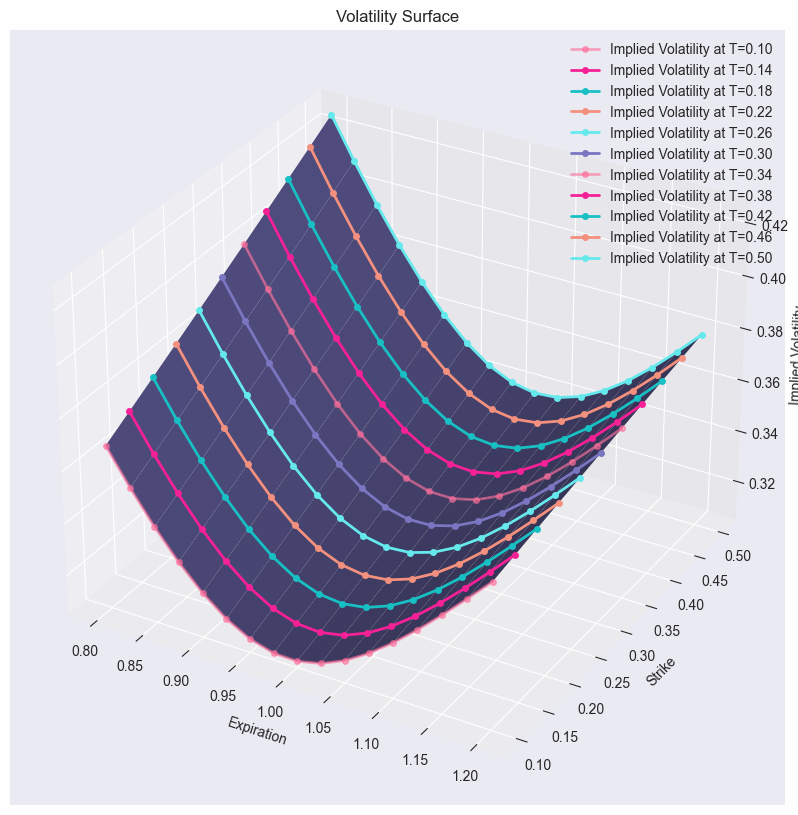

In [104]:
expiration_grid, strike_grid = np.meshgrid(
    sorted(df['expirations'].unique()), 
    sorted(df['strikes'].unique())
)

iv_grid = np.zeros_like(expiration_grid, dtype=np.float64)
for i, exp in enumerate(sorted(df['expirations'].unique())):
    for j, strike in enumerate(sorted(df['strikes'].unique())):
        iv_values = df[(df['expirations'] == exp) & (df['strikes'] == strike)]['ivs']
        iv_grid[j, i] = iv_values.mean() if not iv_values.empty else np.nan

fig = plt.figure(figsize=(10, 15))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(
    strike_grid, expiration_grid, iv_grid 
)

for t in sorted(df['expirations'].unique()):
    strikes_for_t = sorted(df[df['expirations'] == t]['strikes'].unique())
    iv_values_for_t = df[df['expirations'] == t].sort_values(by='strikes')['ivs'].values
    ax.plot(
        strikes_for_t, 
        [t] * len(strikes_for_t), 
        iv_values_for_t, 
        linewidth=2, marker="o", markersize=4, 
        label=f"Implied Volatility at T={t:.2f}"
    )
    
ax.set_xlabel('Expiration')
ax.set_ylabel('Strike')
ax.set_zlabel('Implied Volatility')
ax.set_title('Volatility Surface')

plt.legend()
plt.show()

In [105]:
iv_grid[1:5]

array([[0.35435405, 0.35979606, 0.36528659, 0.37082544, 0.3764124 ,
        0.38204726, 0.38772981, 0.39345985, 0.39923716, 0.40506155,
        0.4109328 ],
       [0.34218495, 0.34736966, 0.35260593, 0.35789349, 0.3632321 ,
        0.3686215 , 0.37406144, 0.37955164, 0.38509186, 0.39068182,
        0.39632127],
       [0.33142241, 0.33632183, 0.34127644, 0.346286  , 0.35135021,
        0.3564688 , 0.36164146, 0.3668679 , 0.3721478 , 0.37748085,
        0.38286673],
       [0.32232127, 0.326902  , 0.33154187, 0.33624069, 0.34099825,
        0.34581428, 0.35068852, 0.35562067, 0.3606104 , 0.36565739,
        0.37076128]])

In [106]:
# iv_grid_data = []
# for i, exp in enumerate(sorted(df['expirations'].unique())):
#     for j, strike in enumerate(sorted(df['strikes'].unique())):
#         iv_grid_data.append({
#             "expirations": exp,
#             "strikes": strike,
#             "iv_grid": iv_grid[j, i]
#         })

# iv_grid_df = pd.DataFrame(iv_grid_data)

# mape = mean_absolute_percentage_error(df['ivs'], iv_grid_df['iv_grid'])

# print(f"Mean Absolute Percentage Error (MAPE): {mape * 100:.2f}%")

In [107]:
iv_data = []
for t in sorted(df['expirations'].unique()):
    strikes_for_t = sorted(df[df['expirations'] == t]['strikes'].unique())
    iv_values_for_t = df[df['expirations'] == t].sort_values(by='strikes')['ivs'].values
    iv_data.extend([(t, strike, iv) for strike, iv, in zip(strikes_for_t, iv_values_for_t)])
iv_df = pd.DataFrame(iv_data, columns=["expiration", "strike", "local_vol"])
iv_df

,expiration,strike,local_vol
0,0.1,0.800,0.367718
1,0.1,0.825,0.354354
2,0.1,0.850,0.342185
3,0.1,0.875,0.331422
4,0.1,0.900,0.322321
...,...,...,...
182,0.5,1.100,0.347837
183,0.5,1.125,0.354335
184,0.5,1.150,0.362031
185,0.5,1.175,0.370607


In [109]:
expiration_grid, strike_grid = np.meshgrid(
sorted(df['expirations'].unique()),
sorted(df['strikes'].unique())
)

iv_grid = np.zeros_like(expiration_grid, dtype=np.float64)
for i, exp in enumerate(sorted(df['expirations'].unique())):
    for j, strike in enumerate(sorted(df['strikes'].unique())):
        iv_values = df[(df['expirations'] == exp) & (df['strikes'] == strike)]['ivs']
        iv_grid[j, i] = iv_values.mean() if not iv_values.empty else np.nan

C:\Users\HONOR\AppData\Local\Temp\ipykernel_20724\407331077.py:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(prop={'size': 13})


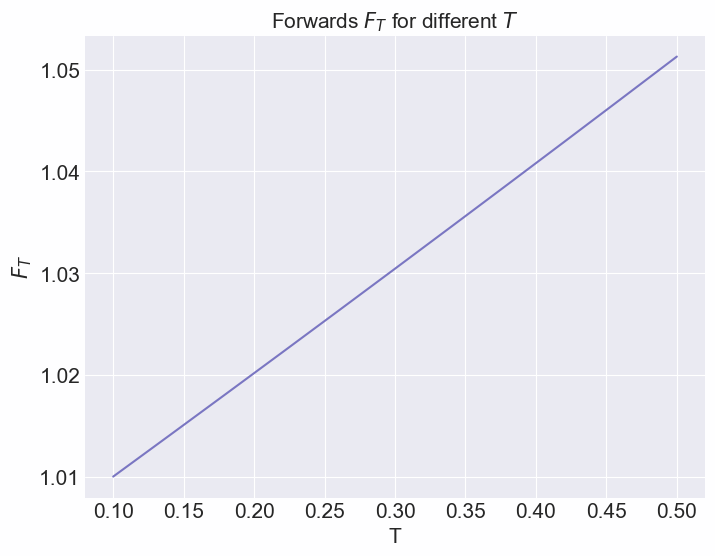

In [110]:
plt.figure(figsize=(8, 6)) 
plt.plot(df2["maturities"], df2["forwards"])   
plt.title("Forwards $F_T$ for different $T$", fontsize=15)
plt.ylabel("$F_T$", fontsize=15)
plt.xlabel("T", fontsize=15)
plt.tick_params(axis='both', labelsize=15)
plt.legend(prop={'size': 13})
plt.grid(True)

C:\Users\HONOR\AppData\Local\Temp\ipykernel_20724\276864070.py:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(prop={'size': 13})


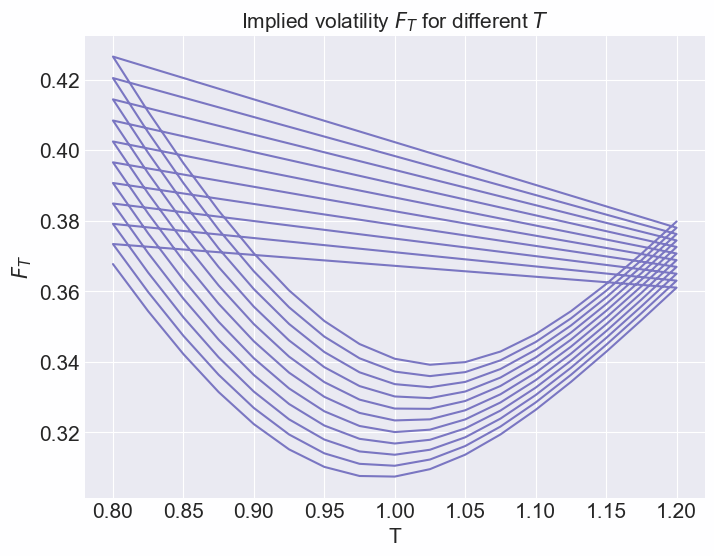

In [111]:
plt.figure(figsize=(8, 6)) 
plt.plot(df["strikes"], df["ivs"])   
plt.title("Implied volatility $F_T$ for different $T$", fontsize=15)
plt.ylabel("$F_T$", fontsize=15)
plt.xlabel("T", fontsize=15)
plt.tick_params(axis='both', labelsize=15)
plt.legend(prop={'size': 13})
plt.grid(True)

In [114]:
for tenor in sorted(df['expirations'].unique()):
    df_tenor = df[df['expirations'] == tenor]
    df_tenor = df_tenor.sort_values(by='strikes')
    
    ax.plot(df_tenor['strikes'], df_tenor['ivs'], label=f"T = {tenor}")

# Настраиваем график
ax.set_xlabel("Strike (K)")
ax.set_ylabel("Implied Volatility (IV)")
ax.set_title("Implied Volatility vs. Strike for Different Tenors")
ax.legend()
ax.grid(True)

plt.show()

In [115]:
df1 = pd.read_csv("options.csv")
df2 = pd.read_csv("forwards.csv")
df = df.rename(columns={"# expiration": "expiration", ' strike': 'strike', ' iv': 'iv'})
j = 0
df1["forwards"] = 0
prev = df1.loc[0, "expirations"] # = df1["expirations"][0]
print(len(df1))
for i in range(len(df1)):
    if (prev != df1.loc[i, "expirations"]):
        prev = df1.loc[i + 1, "expirations"]
        j += 1
    if df1.loc[i, "expirations"] == df2.loc[j, "maturities"]:
        df1.loc[i, "forwards"] = df2.loc[j, "forwards"]
df1

187


C:\Users\HONOR\AppData\Local\Temp\ipykernel_20724\542742140.py:13: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1.010050167084168' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df1.loc[i, "forwards"] = df2.loc[j, "forwards"]


,expirations,strikes,ivs,forwards
0,0.1,0.800,0.367718,1.010050
1,0.1,0.825,0.354354,1.010050
2,0.1,0.850,0.342185,1.010050
3,0.1,0.875,0.331422,1.010050
4,0.1,0.900,0.322321,1.010050
...,...,...,...,...
182,0.5,1.100,0.347837,1.051271
183,0.5,1.125,0.354335,1.051271
184,0.5,1.150,0.362031,1.051271
185,0.5,1.175,0.370607,1.051271


In [116]:
implied_vols = df1["ivs"]
forward = df1["forwards"]
strikes = df1["strikes"]
expirations = df1["expirations"]
implied_vols

0      0.367718
1      0.354354
2      0.342185
3      0.331422
4      0.322321
         ...   
182    0.347837
183    0.354335
184    0.362031
185    0.370607
186    0.379797
Name: ivs, Length: 187, dtype: float64

In [117]:
# import csv 
# import json
# import time

# def csv_to_json(csvFilePath, jsonFilePath):
#     jsonArray = []
      
#     #read csv file
#     with open(csvFilePath, encoding='utf-8') as csvf: 
#         #load csv file data using csv library's dictionary reader
#         csvReader = csv.DictReader(csvf) 

#         #convert each csv row into python dict
#         for row in csvReader: 
#             #add this python dict to json array
#             jsonArray.append(row)
  
#     #convert python jsonArray to JSON String and write to file
#     with open(jsonFilePath, 'w', encoding='utf-8') as jsonf: 
#         jsonString = json.dumps(jsonArray, indent=4)
#         jsonf.write(jsonString)
          
# csvFilePath = r'options.csv'
# jsonFilePath = r'options.json'

# csv_to_json(csvFilePath, jsonFilePath)

In [118]:
import json
f = open('options.json')
data = json.load(f)

In [119]:
spot = data["S0"]
implied_vols = data["IV"]
implied_vols

{'0.1': {'iv': [0.3677179516655335,
   0.3543540498045074,
   0.3421849506557801,
   0.3314224093477623,
   0.3223212698651677,
   0.3151600611868606,
   0.31019884946258,
   0.3076165257964298,
   0.3074482792396077,
   0.3095570867450963,
   0.3136595050479295,
   0.3193914459663687,
   0.326378421562691,
   0.3342838139402285,
   0.3428300072310612,
   0.3518002455191933,
   0.361030983963396],
  'strikes': [0.8,
   0.8250000000000001,
   0.8500000000000001,
   0.875,
   0.9,
   0.925,
   0.95,
   0.975,
   1.0,
   1.025,
   1.05,
   1.075,
   1.1,
   1.125,
   1.15,
   1.1749999999999998,
   1.2]},
 '0.14': {'iv': [0.373395756050272,
   0.3597960579153613,
   0.3473696630891169,
   0.336321828618122,
   0.3269019994962273,
   0.3193872479794426,
   0.314043905359186,
   0.3110675116494895,
   0.3105186275993428,
   0.3122872507633814,
   0.3161099217179053,
   0.3216308461550917,
   0.3284732649574369,
   0.3362919572647396,
   0.344798489342173,
   0.353765664439602,
   0.36302102

<>:10: SyntaxWarning: invalid escape sequence '\s'
<>:10: SyntaxWarning: invalid escape sequence '\s'
C:\Users\HONOR\AppData\Local\Temp\ipykernel_20724\1462042966.py:10: SyntaxWarning: invalid escape sequence '\s'
  plt.title("$\sigma_{IV}(T, \cdot)$ for different T", fontsize=15)


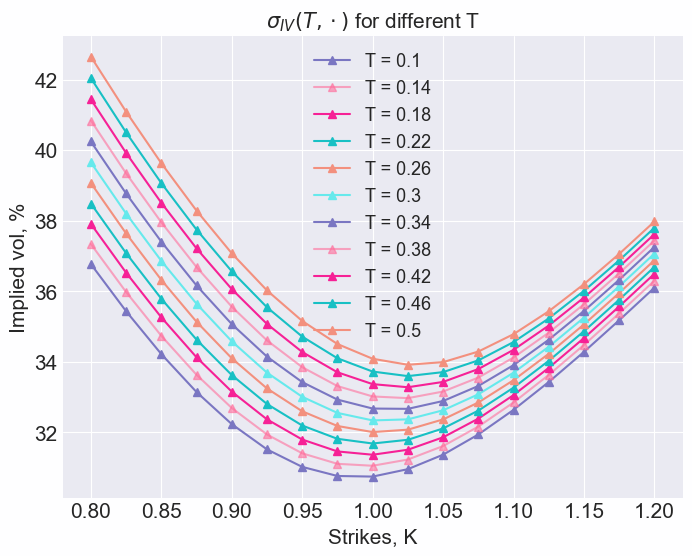

In [120]:
plt.figure(figsize=(8, 6))

for tenor, iv in implied_vols.items():
    ind = np.random.randint(100)
    strikes_ = iv["strikes"]
    implied_vols_for_tenor_ = iv["iv"]
    label="T = {}".format(round(float(tenor), 2))
    plt.plot(strikes_, 100 * np.array(implied_vols_for_tenor_), label=label, marker = "^")
    
plt.title("$\sigma_{IV}(T, \cdot)$ for different T", fontsize=15)
plt.ylabel("Implied vol, %", fontsize=15)
plt.xlabel("Strikes, K", fontsize=15)
plt.tick_params(axis='both', labelsize=15)
plt.legend(prop={'size': 13})
plt.grid(True)

In [121]:
for i in range(df2.shape[0]):
    k = np.log(df2["forwards"][i]) / df2["maturities"][i]
    print(k)

0.09999999999999892
0.10000000000000098
0.09999999999999964
0.09999999999999974
0.09999999999999971
0.10000000000000027
0.10000000000000009
0.09999999999999983
0.1
0.10000000000000006
0.09999999999999973


In [122]:
s = 1.0
r = 0.1

In [124]:
def forward(time_to_maturity):
    return df2.loc[df2['maturities'] == time_to_maturity, 'forwards'].values[0]

In [125]:
implied_vols = {}
for expiration, group in df.groupby("expirations"):
    implied_vols[expiration] = {
        "strikes": group["strikes"].values,
        "iv": group["ivs"].values,
    }

In [126]:
def dupire_for_appropriate_strikes(implied_vols: dict,
                                   forward,
                                   strikes: np.array):
    """
        Calculates local volatility function from IV curves for different tenors. 
            implied_vols (dict): dict of implied vol curves. 
            forward: function returning the forward on specific tenor.
            strikes (np.array): array of strikes.
    """
    strikes = np.array(strikes, dtype=float)
    iv_2_at_k = np.empty((len(implied_vols.keys()), len(strikes)))
    iv_2_at_k[:,:] = np.nan
    time_grid = []
    for i, t in enumerate(implied_vols.keys()):
        time_to_maturity = float(t)
        time_grid.append(time_to_maturity)
        strike_t = np.array(implied_vols[t]['strikes'], dtype=float)
        iv_t = np.array(implied_vols[t]['iv'], dtype=float)

        # интерполируем кубическими сплайнами в координатах соответственно total variance и log forward moneyness, и дальше получаем implied_vol в этих точках при всех К
        implied_vol_surface_t_squared = interp1d(np.log(strike_t / forward(time_to_maturity)), time_to_maturity * iv_t ** 2, kind='cubic', fill_value='extrapolate')
        
        # From obtained interpolator, retrieve variances at given strikes. 
        iv_2_at_k[i,:] = implied_vol_surface_t_squared(np.log(strikes / forward(time_to_maturity))) / time_to_maturity
    
    time_grid = np.array(time_grid)

    # total variances w
    w_at_k = iv_2_at_k * np.tile(time_grid.reshape(-1, 1), (1, strikes.shape[0]))
    w_interp = RectBivariateSpline(time_grid, np.log(strikes / forward(time_to_maturity)), w_at_k, s=0.1)
    
    # partial derivatives of w 
    dw_dt = w_interp.partial_derivative(dx=1, dy=0)
    dw_dlogK = w_interp.partial_derivative(dx=0, dy=1)
    d2w_dlogK2 = w_interp.partial_derivative(dx=0, dy=2)

    local_vol_squared = lambda t, logForwMoneyness: dw_dt(t, logForwMoneyness, grid=False) / (
                    1 - logForwMoneyness / w_interp(t, logForwMoneyness, grid=False) * dw_dlogK(t, logForwMoneyness, grid=False) 
                    + 0.25 * (-0.25 - 1 / w_interp(t, logForwMoneyness, grid=False) + logForwMoneyness * logForwMoneyness / (w_interp(t, logForwMoneyness, grid=False)**2)) * dw_dlogK(t, logForwMoneyness, grid=False)**2 
                    + 0.5 * d2w_dlogK2(t, logForwMoneyness, grid=False))

    local_vol = lambda t, k: np.sqrt(local_vol_squared(t, np.log(k / forward(t))))
    # локальная волатильность эта ф-ция 2-х переменных T и K, ф-ция lambda t, k: которая возвращает результат численного дифференцирования и применения ф-лы Дюпира к implied_vol 
    return local_vol

In [127]:
local_vol = dupire_for_appropriate_strikes(implied_vols, forward, np.array(sorted(df['strikes'].unique())))
local_vol

<function __main__.dupire_for_appropriate_strikes.<locals>.<lambda>(t, k)>

In [57]:
# forward_dict = df2.set_index("maturities")["forwards"].to_dict()

# def forward(time_to_maturity):
#     return forward_dict.get(time_to_maturity, 0)

# local_vol = dupire_for_appropriate_strikes(implied_vols, forward, strikes)
# local_vol

In [64]:
# fig = plt.figure(figsize=(10, 10))
# x, y = np.meshgrid(sorted(df['strikes'].unique()), sorted(df['expirations'].unique()))

# ax1 = fig.add_subplot(projection='3d')
# ax1.plot_surface(x, y, local_vol(y, x))
# for t, iv in implied_vols.items():
#     ax1.plot(iv["strikes"], 
#              [float(t)] * len(iv["strikes"]), 
#              local_vol(float(t), iv["strikes"]), 
#              linewidth=2, marker="o", markersize=2, label="$\\sigma_{Dup}(t, s)$, t = " + format(round(float(t), 2)))
# ax1.set_title('Market Dupire local volatility surface', fontsize=20)
# ax1.set_xlabel('Strike, K', fontsize=15)
# ax1.set_ylabel('Time to expiration, T', fontsize=15)
# ax1.set_zlabel('Local volatility $\\sigma_{Dup}(t, s)$', fontsize=15)
# ax1.legend()

x shape: (11, 17), y shape: (11, 17)
local_vol(y, x) shape: (11, 17)


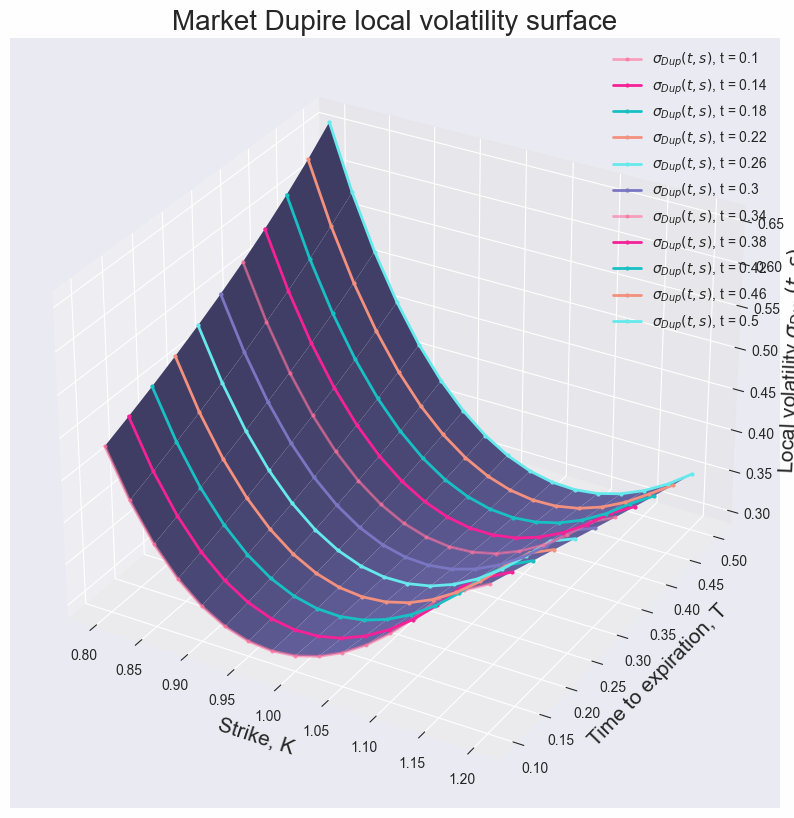

In [128]:
fig = plt.figure(figsize=(10, 10))
x, y = np.meshgrid(sorted(df['strikes'].unique()), sorted(df['expirations'].unique()))
print(f"x shape: {x.shape}, y shape: {y.shape}")
#print(f"local_vol(y, x) shape: {local_vol(y, x).shape}")

ax1 = fig.add_subplot(projection='3d')
z = np.vectorize(local_vol)(y, x)
print(f"local_vol(y, x) shape: {z.shape}")
# ax1.plot_surface(x, y, local_vol(y, x))
ax1.plot_surface(x, y, z)
for tenor, iv in implied_vols.items():
    tenor = float(tenor)
    strikes = iv["strikes"]
    implied_vols_for_tenor = iv["iv"]
    ax1.plot(strikes, 
             [tenor] * len(strikes), 
             local_vol(tenor, strikes), 
             linewidth=2, marker="o", markersize=2, label="$\\sigma_{Dup}(t, s)$, t = " + format(round(float(tenor), 2)))    
ax1.set_title('Market Dupire local volatility surface', fontsize=20)
ax1.set_xlabel('Strike, K', fontsize=15)
ax1.set_ylabel('Time to expiration, T', fontsize=15)
ax1.set_zlabel('Local volatility $\\sigma_{Dup}(t, s)$', fontsize=15)
ax1.legend()
plt.show()

In [129]:
implied_vol_data = []

for t in sorted(df['expirations'].unique()):
    strikes_for_t = sorted(df[df['expirations'] == t]['strikes'].unique())
    iv_values_for_t = df[df['expirations'] == t].sort_values(by='strikes')['ivs'].values
    for strike, iv in zip(strikes_for_t, iv_values_for_t):
        implied_vol_data.append({'expiration': t, 'strike': strike, 'implied_vol': iv})

implied_vol_df = pd.DataFrame(implied_vol_data)


local_vol_data = []

for t in sorted(df['expirations'].unique()):
    strikes_for_t = sorted(df[df['expirations'] == t]['strikes'].unique())
    local_vol_values_for_t = [local_vol(t, strike) for strike in strikes_for_t]
    for strike, local_vol_value in zip(strikes_for_t, local_vol_values_for_t):
        local_vol_data.append({'expiration': t, 'strike': strike, 'local_vol': local_vol_value})

local_vol_df = pd.DataFrame(local_vol_data)

#mape = mean_absolute_percentage_error(local_vol_df['local_vol'], df['ivs'])
#print(f"Mean Absolute Percentage Error (MAPE) between implied volatility and local volatility: {mape:.2f}%")

merged_df = pd.merge(implied_vol_df, local_vol_df, on=['expiration', 'strike'])

mape_value = 100 * mean_absolute_percentage_error(merged_df['local_vol'], merged_df['implied_vol']).mean()
print(f"Mean Absolute Percentage Error (MAPE) between implied volatility and local volatility: {mape_value:.2f}%")

print(merged_df[['expiration', 'strike', 'implied_vol', 'local_vol']])


Mean Absolute Percentage Error (MAPE) between implied volatility and local volatility: 10.16%
     expiration  strike  implied_vol  local_vol
0           0.1   0.800     0.367718   0.483999
1           0.1   0.825     0.354354   0.428094
2           0.1   0.850     0.342185   0.384481
3           0.1   0.875     0.331422   0.351454
4           0.1   0.900     0.322321   0.327580
..          ...     ...          ...        ...
182         0.5   1.100     0.347837   0.295742
183         0.5   1.125     0.354335   0.303829
184         0.5   1.150     0.362031   0.316241
185         0.5   1.175     0.370607   0.332828
186         0.5   1.200     0.379797   0.353441

[187 rows x 4 columns]


In [130]:
local_vol_df['local_vol'], df['ivs']

(0      0.483999
 1      0.428094
 2      0.384481
 3      0.351454
 4      0.327580
          ...   
 182    0.295742
 183    0.303829
 184    0.316241
 185    0.332828
 186    0.353441
 Name: local_vol, Length: 187, dtype: float64,
 0      0.367718
 1      0.354354
 2      0.342185
 3      0.331422
 4      0.322321
          ...   
 182    0.347837
 183    0.354335
 184    0.362031
 185    0.370607
 186    0.379797
 Name: ivs, Length: 187, dtype: float64)

In [131]:
local_vol_data = []

# Loop over each tenor and calculate the local volatility for each strike
for tenor, iv in implied_vols.items():
    tenor = float(tenor)
    strikes = iv["strikes"]
    implied_vols_for_tenor = iv["iv"]

    local_vol_for_tenor = local_vol(tenor, strikes)
    
    for strike, implied_vol, local_v in zip(strikes, implied_vols_for_tenor, local_vol_for_tenor):
        local_vol_data.append({
            "expiration": tenor, 
            "strike": strike,
            "local_vol": local_v  # Implied volatility from the local volatility model
        })

local_vol_df = pd.DataFrame(local_vol_data)

mape = mean_absolute_percentage_error(local_vol_df['local_vol'], df['ivs'])

print(f"Mean Absolute Percentage Error (MAPE): {mape * 100:.2f}%")

Mean Absolute Percentage Error (MAPE): 10.16%


<>:11: SyntaxWarning: invalid escape sequence '\s'
<>:18: SyntaxWarning: invalid escape sequence '\s'
<>:11: SyntaxWarning: invalid escape sequence '\s'
<>:18: SyntaxWarning: invalid escape sequence '\s'
C:\Users\HONOR\AppData\Local\Temp\ipykernel_20724\1858749761.py:11: SyntaxWarning: invalid escape sequence '\s'
  ax1.set_title("$ \sigma_{IV}(T, \cdot)$ for different T", fontsize=15)
C:\Users\HONOR\AppData\Local\Temp\ipykernel_20724\1858749761.py:18: SyntaxWarning: invalid escape sequence '\s'
  ax2.set_title("$ \sigma_{loc}(T, \cdot)$ for different T", fontsize=15)


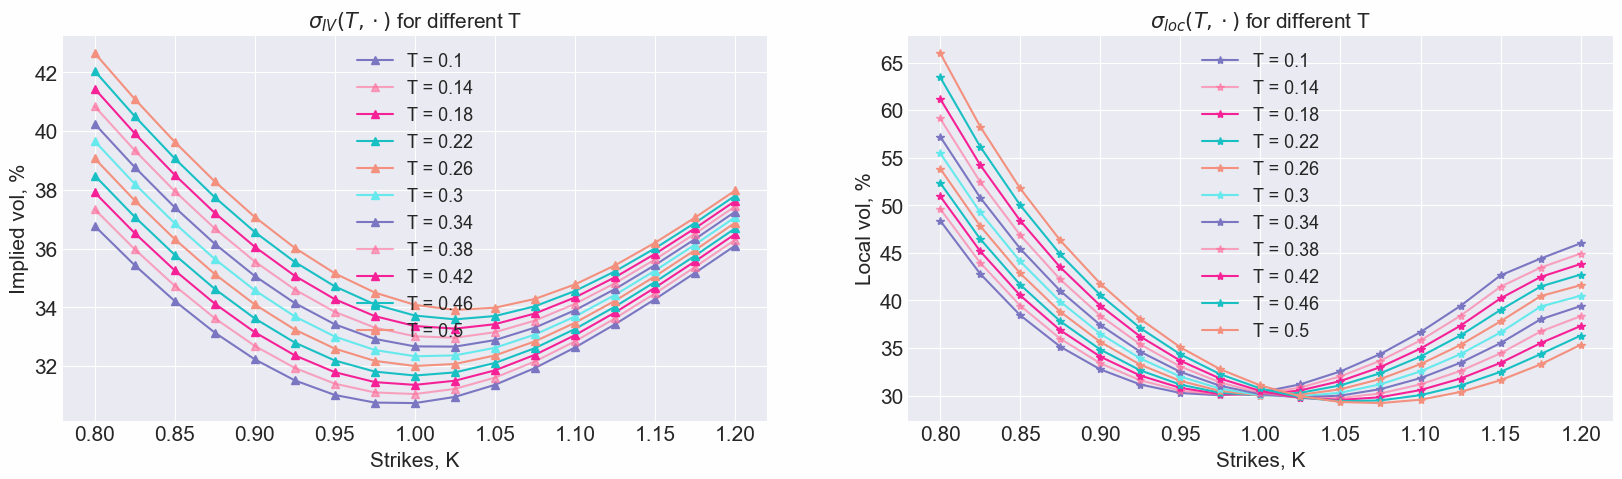

In [90]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))

for tenor, iv in implied_vols.items():
    tenor = float(tenor)
    strikes = iv["strikes"]
    implied_vols_for_tenor = iv["iv"]
    label="T = {}".format(round(tenor, 2))
    ax1.plot(strikes, 100 * np.array(implied_vols_for_tenor), label=label, marker = "^")
    ax2.plot(strikes, 100 * local_vol(tenor, strikes), label=label, marker = "*")
    
    ax1.set_title("$\sigma_{IV}(T, \cdot)$ for different T", fontsize=15)
    ax1.set_ylabel("Implied vol, %", fontsize=15)
    ax1.set_xlabel("Strikes, K", fontsize=15)
    ax1.tick_params(axis='both', labelsize=15)
    ax1.legend(prop={'size': 13})
    ax1.grid(True)

    ax2.set_title("$\sigma_{loc}(T, \cdot)$ for different T", fontsize=15)
    ax2.set_ylabel("Local vol, %", fontsize=15)
    ax2.set_xlabel("Strikes, K", fontsize=15)
    ax2.tick_params(axis='both', labelsize=15)
    ax2.legend(prop={'size': 13})
    ax2.grid(True)

In [132]:
local_vol_data = []

for tenor, iv in implied_vols.items():
    tenor = float(tenor)
    strikes = iv["strikes"]
    implied_vols_for_tenor = iv["iv"]

    local_vol_for_tenor = local_vol(tenor, strikes)
    
    for strike, implied_vol, local_v in zip(strikes, implied_vols_for_tenor, local_vol_for_tenor):
        local_vol_data.append({
            "expiration": tenor, 
            "strike": strike,
            "local_vol": local_v
        })

local_vol_df = pd.DataFrame(local_vol_data)

mape = mean_absolute_percentage_error(local_vol_df['local_vol'], df['ivs'])

print(f"Mean Absolute Percentage Error (MAPE): {mape * 100:.2f}%")

Mean Absolute Percentage Error (MAPE): 10.16%
